In [1]:
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from numpy.polynomial import legendre
import pandas as pd
from datetime import datetime
from scipy.stats import multivariate_normal
from scipy.special import erf
from scipy.special import hyp1f1
from scipy.linalg import eigh
from random import randint
from scipy.optimize import fsolve
from scipy.optimize import root
from numpy.polynomial import legendre

In [2]:
rawdata = pd.read_excel("./NYPD_Motor_Vehicle_Collisions.xlsx")

In [3]:
df=rawdata.loc[:,['DATE','TIME']]

In [4]:
df['DATE']=pd.to_datetime(df['DATE'])

In [359]:
training=[]

In [360]:
training_wk=[]

In [370]:
start=np.datetime64('2017-10-09')       # June, July, August
end=np.datetime64('2017-10-13')
interval = pd.date_range(start, end)

In [1065]:
len(training)

17

In [372]:
for i in interval:
    df_1=df[df['DATE']==i]

    df_1['ts']=df_1.apply(lambda r : pd.datetime.combine(r['DATE'],r['TIME']),1)

    df_1['ts']=df_1['ts'].astype(np.int64)

    df_1=df_1.sort_values(['ts'])

    training_data=df_1['ts'].values/1000000000  # convert to second

    training_data=training_data-training_data[0]+1

    training_data=training_data/60      # convert to minite, T=1440
    training_data=training_data/10      # convert to 10 minite, T=144
    
    for i in range(20):                 # delete points at 0
        if training_data[0]==training_data[1]:
            training_data=np.delete(training_data,1)
            
    for i in range(1,len(training_data)):  # divide points at same time
        for j in range(i):
            if training_data[j]==training_data[i]:
                training_data[i]+=0.01

    training.append(list(training_data))

C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [542]:
np.average([len(training[i]) for i in range(17)])

629.0588235294117

In [391]:
del training[16][:10]

In [886]:
for i in range(len(training)):
    training[i]=np.sort(training[i])

In [1066]:
T=144

In [1067]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [1068]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [1069]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [1070]:
T_phi=6

In [1071]:
xi=np.linspace(0+(T_phi/10)/2,T_phi-(T_phi/10)/2,6)   # 6 inducing points on \phi(\tau)

In [1072]:
xi_mu=np.linspace(0,T,8)   # 8 inducing points, T is larger so we need more points

In [1073]:
theta0=1
theta1=2

In [1074]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [1075]:
f=GP_regression(xi,u,theta0,theta1,0.000001,T_phi,100) # f is 100-dimension vector on [0,T_phi]

In [1076]:
def eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for i in range(1,len(k_K_k)):
        for j in range(i):
            if P[i][j]!=0:
                y+=k_K_K_k[i][j][m]*P[i][j]/(k_K_k[i][j]+sum([(k_K[i][j][k]**2)*s[k] for k in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [1077]:
def equations(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [1078]:
def ini_P(points_hawkes,T_phi):
    N=len(points_hawkes)
    P=np.zeros((N,N))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1))
                break
    return P

In [1079]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [1080]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
#     cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    var_f=np.array([theta0-K_xz[i].dot(cov_p_u_inv).dot(K_xz[i].T)+(((K_xz[i].dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz[i].T) for i in range(M)])
    
    exp_phi=var_f
    return exp_phi

In [1081]:
theta0_mu=1
theta1_mu=0.01

In [1082]:
u_mu,mean_p_u_mu,cov_p_u_mu=u_generate(theta0_mu,theta1_mu,xi_mu)

In [1083]:
f_mu=GP_regression(xi_mu,u_mu,theta0_mu,theta1_mu,0.000001,T,500) # f is 1000-dimension vector on [0,T]

In [1084]:
def eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for n in range(len(k_K_k)):
        if P[n][n]!=0:
            y+=k_K_K_k[n][m]*P[n][n]/(k_K_k[n]+sum([(k_K[n][i]**2)*s[i] for i in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [1085]:
def equations_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [1086]:
def MISD_variational_deri(points_hawkes,xi,xi_mu,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points on phi
    M_mu=len(xi_mu)      # num of inducing points on mu
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    delta_t_mu=T/len(f_mu[0]) # u(t) is descrete to 500 points
    
    
    #_______________________initial setting of mu
    cov_q_u_mu_diag=np.random.uniform(0,1,M_mu)  ## initial of cov_q_u_mu_diag
    k_tn_z_mu=np.zeros((N,M_mu))
    for i in range(N):
        for j in range(M_mu):
            k_tn_z_mu[i][j]=expo_quad_kernel(theta0_mu,theta1_mu,points_hawkes[i],xi_mu[j])
            
    cov_p_u_mu_inv=np.linalg.inv(cov_p_u_mu)
    thirdterm_mu=np.diagonal(cov_p_u_mu_inv)
    Psi_mu=np.zeros((M_mu,M_mu))
    for i in range(M_mu):
        for j in range(i,M_mu):
            Psi_mu[i][j]=psi(theta0_mu,theta1_mu,xi_mu[i],xi_mu[j],T)
            Psi_mu[j][i]=Psi_mu[i][j]
    secondterm_mu=np.diagonal(cov_p_u_mu_inv.dot(Psi_mu).dot(cov_p_u_mu_inv))
    
    k_K_K_k_mu=np.empty((0,M_mu))   #vector of vector   #     1st term
    k_K_k_mu=np.array([])    # vecotr of value
    k_K_mu=np.empty((0,M_mu))      # vector of vector
    for i in range(N):
        k_K_K_k_mu=np.append(k_K_K_k_mu, np.array([np.diagonal(cov_p_u_mu_inv.dot(np.array([k_tn_z_mu[i]]).T).dot(np.array([k_tn_z_mu[i]])).dot(cov_p_u_mu_inv))]),axis=0)
        k_K_k_mu=np.append(k_K_k_mu,theta0_mu-k_tn_z_mu[i].dot(cov_p_u_mu_inv).dot(k_tn_z_mu[i].T))
        k_K_mu=np.append(k_K_mu,np.array([k_tn_z_mu[i].dot(cov_p_u_mu_inv)]),axis=0) 
    
    #__________________initial setting of phi
    cov_q_u_diag=np.random.uniform(0,1,M)
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    thirdterm=np.diagonal(cov_p_u_inv)
    n_1=sum(np.array(points_hawkes)<(T-T_phi)) # num of points within T-T_phi
    Psi=np.zeros((N,M,M))
    for i in range(n_1):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T_phi)
                Psi[i][k][j]=Psi[i][j][k]
    for i in range(n_1,N):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T-points_hawkes[i])
                Psi[i][k][j]=Psi[i][j][k]
    secondterm=sum([np.diagonal(cov_p_u_inv.dot(Psi[i]).dot(cov_p_u_inv)) for i in range(N)])
    k_tn_z=np.zeros((N,N,M))
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                tao=points_hawkes[i]-points_hawkes[j]
                k_tn_z[i][j]=np.array([expo_quad_kernel(theta0,theta1,tao,xi[k]) for k in range(M)])            
    k_K_K_k=np.zeros((N,N,M))   # matrix of vector   #     1st term
    k_K_k=np.zeros((N,N))    # matrix of value
    k_K=np.zeros((N,N,M))     # matrix of vector
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                k_K_K_k[i][j]=np.diagonal(cov_p_u_inv.dot(np.array([k_tn_z[i][j]]).T).dot(np.array([k_tn_z[i][j]])).dot(cov_p_u_inv))
                k_K_k[i][j]=theta0-k_tn_z[i][j].dot(cov_p_u_inv).dot(k_tn_z[i][j].T)
                k_K[i][j]=k_tn_z[i][j].dot(cov_p_u_inv)
    
    
    
    
    
    for k in range(num_iter):  # num of iterations
        # update of phi
        
        cov_q_u_diag=fsolve(equations,cov_q_u_diag, args=(P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M))
        cov_q_u_diag[cov_q_u_diag<0] = 0.1 # more stable
        cov_q_u=np.diag(cov_q_u_diag)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        # update of mu
        
        cov_q_u_mu_diag=fsolve(equations_mu,cov_q_u_mu_diag, args=(P,k_K_mu,k_K_k_mu,k_K_K_k_mu,secondterm_mu,thirdterm_mu,M_mu))
        cov_q_u_mu_diag[cov_q_u_mu_diag<0] = 0.1 # more stable
        cov_q_u_mu=np.diag(cov_q_u_mu_diag)
        mu=distribution_f_posterior(f_mu[0],xi_mu,theta0_mu,theta1_mu,cov_p_u_mu,cov_q_u_mu)

        
        for i in range(N): # updata of P
            mu_ti=mu[int(points_hawkes[i]/delta_t_mu)]
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu_ti
            P[i][i]=mu_ti/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [1047]:
%%time
mu_var_multiple=[]
phi_var_multiple=[]
for i in range(12,13):
    mu_var,phi_var=MISD_variational_deri(training[i],xi,xi_mu,T_phi,T,100)
    mu_var_multiple.append(mu_var)
    phi_var_multiple.append(phi_var)

Wall time: 39min 38s


In [1048]:
mu_var=np.average(np.array(mu_var_multiple),axis=0)
phi_var=np.average(np.array(phi_var_multiple),axis=0)

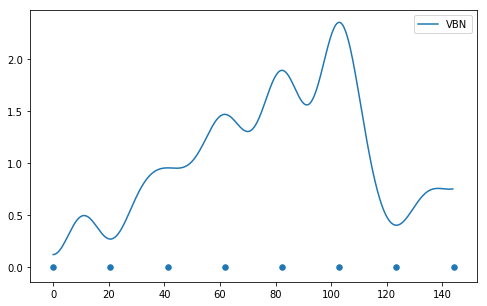

In [1051]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f_mu[0],mu_var,label='VBN')
axs.scatter(xi_mu,np.zeros((len(xi_mu))),marker='o',s=30)
plt.legend()
plt.show()

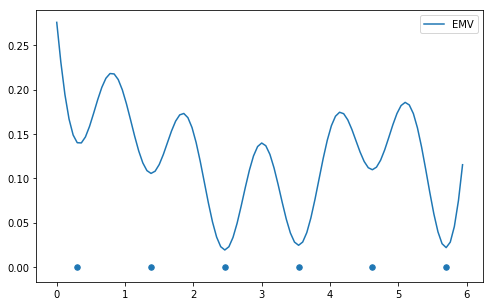

In [1052]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f[0],phi_var,label='EMV')
axs.scatter(xi,np.zeros((len(xi))),marker='o',s=30)
plt.legend()
plt.show()

## MISD

In [1087]:
def MISD(points_hawkes,T,T_gamma,delta_t,num_iter):
    num_g=int(T_gamma/delta_t)
    N=len(points_hawkes)
    P=ini_P(points_hawkes,T_gamma)
    g=np.zeros((1,num_g), dtype=float)

    for k in range(num_iter):
        for m in range(num_g): # update for u and g
            rate_prob=np.zeros((1,N))
            div_num=0
            for i in range(N):
                if (T-points_hawkes[i])>=m*delta_t and (T-points_hawkes[i])<(m+1)*delta_t: # point i is close to T
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/(T-m*delta_t)
                elif (T-points_hawkes[i])<m*delta_t:
                    break
                else:
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/delta_t
            if div_num==0:
                break
            else:
                g[0][m]=sum(rate_prob[0])/div_num
        u=sum(P[i][i] for i in range(N))/T

        for i in range(N): # updata for P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: continue
                intensity_total+=g[0][int(tji/delta_t)]
            intensity_total+=u
            P[i][i]=u/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: P[i][j]=0
                else: P[i][j]=g[0][int(tji/delta_t)]/intensity_total
    return u,g[0]

In [1088]:
%%time
u_misd_6_multiple=[]
phi_misd_6_multiple=[]
for i in range(2):
    u_misd_6,phi_misd_6=MISD(training[i],T,T_phi,1,100)
    u_misd_6_multiple.append(u_misd_6)
    phi_misd_6_multiple.append(phi_misd_6)

Wall time: 1min 23s


In [1089]:
u_misd_6=np.average(np.array(u_misd_6_multiple))
phi_misd_6=np.average(np.array(phi_misd_6_multiple),axis=0)

In [1090]:
%%time
u_misd_8_multiple=[]
phi_misd_8_multiple=[]
for i in range(2):
    u_misd_8,phi_misd_8=MISD(training[i],T,T_phi,0.75,100)
    u_misd_8_multiple.append(u_misd_8)
    phi_misd_8_multiple.append(phi_misd_8)

Wall time: 1min 20s


In [1091]:
u_misd_8=np.average(np.array(u_misd_8_multiple))
phi_misd_8=np.average(np.array(phi_misd_8_multiple),axis=0)

In [423]:
%%time
u_misd_10_multiple=[]
phi_misd_10_multiple=[]
for i in range(1):
    u_misd_10,phi_misd_10=MISD(training[i],T,T_phi,0.6,100)
    u_misd_10_multiple.append(u_misd_10)
    phi_misd_10_multiple.append(phi_misd_10)

Wall time: 35.2 s


In [424]:
u_misd_10=np.average(np.array(u_misd_10_multiple))
phi_misd_10=np.average(np.array(phi_misd_10_multiple),axis=0)

In [426]:
%%time
u_misd_12_multiple=[]
phi_misd_12_multiple=[]
for i in range(1):
    u_misd_12,phi_misd_12=MISD(training[i],T,T_phi,0.5,100)
    u_misd_12_multiple.append(u_misd_12)
    phi_misd_12_multiple.append(phi_misd_12)

Wall time: 33.8 s


In [427]:
u_misd_12=np.average(np.array(u_misd_12_multiple))
phi_misd_12=np.average(np.array(phi_misd_12_multiple),axis=0)

## WH

In [1092]:
def hawkes_second_stats_conti_gauss(t,h,points_hawkes,T):   # gaussian kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(((t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h)**2/2))
            g_t_i.append(sum(g_t)/np.sqrt(2*np.pi)/h)
    return np.average(g_t_i)-Lamda

In [1093]:
def primitive_g(t,g,range_g): # -infinity to t
    delta_t=range_g/len(g)
    num_bin=t/delta_t
    if num_bin<len(g):
        integral=sum(g[:int(num_bin)])*delta_t+g[int(num_bin)]*delta_t*(num_bin-int(num_bin))
    else:
        integral=sum(g)*delta_t
    return integral+sum(g)*delta_t

In [1094]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [1095]:
def phi_WH_prediction(t,g,Q,range_g): 
    delta_t=range_g/len(g) 
    p,w=gq_points_weights(0,range_g,Q)  # (0,infininty) replaced by (0,range_g)
    g_ti=np.zeros((Q,Q))
    G_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        G_ti[i]=primitive_g(p[i],g,range_g)
        for j in range(i,Q):
            if i==j:
                g_ti[i][i]=g[int(p[i]/delta_t)]
            else:
                g_ti[i][j]=g[int((p[j]-p[i])/delta_t)]
                g_ti[j][i]=g_ti[i][j]
    
    a = np.zeros((Q,Q))
    b = np.zeros((1,Q))[0]
    for i in range(Q):
        b[i]=g_ti[i][i]
        for j in range(Q):
            if i==j:
                a[i][i]=1+G_ti[i]-sum(w*g_ti[i])+w[i]*g_ti[i][i]  #diagonal
            else:
                a[i][j]=w[j]*g_ti[i][j]    
    phi_ti = np.linalg.solve(a,b)

    g_t=g[int(t/delta_t)]
    G_t=primitive_g(t,g,range_g)
    g_t_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        g_t_ti[i]=g[int((t-p[i])/delta_t)]
    phi_t=(g_t-sum(w*phi_ti*g_t_ti))/(1+G_t-sum(w*g_t_ti))
    return phi_t

In [1099]:
def phi_parameter(points_hawkes,x,h,Q,range_g):# default range_g*10 points, points should be list
#     x=np.linspace(0.1/2,range_g-0.1/2,range_g*10)
    g_gauss=[hawkes_second_stats_conti_gauss(x_i,h,points_hawkes,T) for x_i in x]
    phi_result=[phi_WH_prediction(xi,g_gauss,Q,range_g) for xi in x]
    
#     mse=sum((np.array(phi_result)-1*np.exp(-2*x))**2)/(range_g*10)
    return phi_result

In [1100]:
%%time
u_wh_multiple=[]
phi_wh_multiple=[]
for i in range(2):
    phi_wh=phi_parameter(list(training[i]),f[0],2,100,T_phi)
    u_wh=len(training[i])/T*(1-sum(T_phi/len(f[0])*np.array(phi_wh)))
    u_wh_multiple.append(u_wh)
    phi_wh_multiple.append(phi_wh)

Wall time: 24.9 s


In [1101]:
u_wh=np.average(np.array(u_wh_multiple))
phi_wh=np.average(np.array(phi_wh_multiple),axis=0)

## parametric Hawkes

In [1102]:
def negtiveloglikelyhood1(parameters, times, T): #times=timestamp t1-tn; T is timespan      fast:R(i)
    times=np.array(times)
    
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=T-times #T-t0...T-t(n-1) 
    timeexponential=np.exp(-beta*timedifference)-1
    secondsum=alpha/beta*sum(timeexponential)
    
    R=np.zeros((len(times),1))
    for i in range(1,len(times)):
        R[i]=np.exp(-beta*(times[i]-times[i-1]))*(1+R[i-1])
    firstsum=sum(np.log(mu+alpha*R))  #left-continuous
    
    negtivelogl=-(firstsum-mu*T+secondsum)
    return negtivelogl

In [1103]:
res=[]
parameters=np.array([1.2,0.7,3])
for i in range(5):
    result=optimize.minimize(negtiveloglikelyhood1, parameters,args=(training[i],T), method='SLSQP', bounds=((0.01,3),(0.01,3),(0.01,3)), options={'disp': True})
    res.append(result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -469.5864607961628
            Iterations: 21
            Function evaluations: 114
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -460.7880811391347
            Iterations: 23
            Function evaluations: 125
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -349.7684741164214
            Iterations: 20
            Function evaluations: 108
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -216.67625848827305
            Iterations: 17
            Function evaluations: 91
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -375.89721925459526
            Iterations: 20
            Fu

In [1104]:
res_ave=np.average(res,axis=0)

In [1105]:
res_ave

array([1.20557479, 2.10410328, 3.        ])

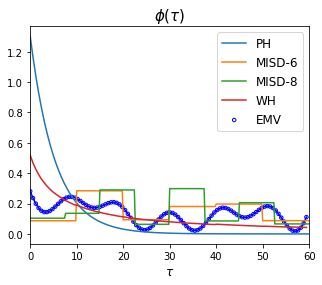

In [563]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(f[0]*10,phi_var,'b')
axs.scatter(f[0]*10,phi_var,marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot(np.linspace(0,6,100)*10,res_ave[1]*np.exp(-res_ave[2]*np.linspace(0,6,100)),label='PH')
axs.plot(np.linspace(0,6,300,endpoint=False)*10,[phi_misd_6[int(xxx/1)] for xxx in np.linspace(0,6,300,endpoint=False)],label='MISD-6')
axs.plot(np.linspace(0,6,300,endpoint=False)*10,[phi_misd_8[int(xxx/0.75)] for xxx in np.linspace(0,6,300,endpoint=False)],label='MISD-8')
axs.plot(f[0]*10,phi_wh,label='WH')
plt.xlabel(r'$\tau$',fontsize=12)
plt.title(r'$\phi(\tau)$',fontsize=15)
plt.xlim(0,60)
# plt.ylim(-0.05,1.2)
plt.xticks(np.arange(0, 65, 10))
plt.legend(fontsize=12)

# plt.savefig('./phi_realdata_1',bbox_inches = 'tight')
plt.show()

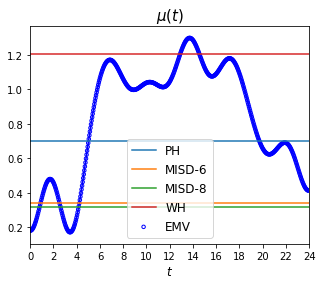

In [564]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(f_mu[0]/6,mu_var,'b')
axs.scatter(f_mu[0]/6,mu_var,marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot([0,T/6],[res_ave[0],res_ave[0]],label='PH')
axs.plot([0,T/6],[u_misd_6,u_misd_6],label='MISD-6')
axs.plot([0,T/6],[u_misd_8,u_misd_8],label='MISD-8')
axs.plot([0,T/6],[u_wh,u_wh],label='WH')
plt.xlabel(r'$t$',fontsize=12)
plt.title(r'$\mu(t)$',fontsize=15)
# plt.ylim(0,1.8)
plt.xlim(0,24)
plt.xticks(np.arange(0, 25, 2))
plt.legend(fontsize=12)

# plt.savefig('./mu_realdata_1',bbox_inches = 'tight')
plt.show()

## log-Like

In [565]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [566]:
def negtiveloglikelihood_discrete(u,g_mean,times,T_phi,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete(times[i],times,u,g_mean,T_phi))
        delta_t=T-times[i]
        if delta_t>=T_phi:
            logl-=sum(g_mean*T_phi/M)
        else:
            temp=(delta_t)*M/T_phi
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*T_phi/M)+g_mean[temp_int]*T_phi/M*(temp-temp_int)
    return -(logl-u*T)

In [567]:
def intensity_discrete_phi_mu(t,history,u,g_mean,g_range,T):    #left continue
    mu=u
    N=len(g_mean)
    M=len(mu)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<g_range:
            intensity_mean+=g_mean[int(delta_t*N/g_range)]
    result=mu[int(t/T*M)]+intensity_mean
    return result

In [568]:
def negtiveloglikelihood_discrete_phi_mu(u,g_mean,g_range,times,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete_phi_mu(times[i],times,u,g_mean,g_range,T))
        delta_t=T-times[i]
        if delta_t>=g_range:
            logl-=sum(g_mean*g_range/M)
        else:
            temp=(delta_t)*M/g_range
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*g_range/M)+g_mean[temp_int]*g_range/M*(temp-temp_int)
    return -(logl-sum(u*T/len(u)))

In [307]:
np.average([-negtiveloglikelihood_discrete(u_misd_6,phi_misd_6,training[i],T_phi,T) for i in range(0,5)])

365.5430812612465

In [308]:
np.average([-negtiveloglikelihood_discrete(u_misd_8,phi_misd_8,training[i],T_phi,T) for i in range(0,5)])

369.8924218707008

In [309]:
np.average([-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),training[i],T_phi,T) for i in range(0,5)])

361.1911805170819

In [310]:
np.average([-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(0,5)])

393.8119157150628

In [311]:
np.average([-negtiveloglikelyhood1(res_ave, training[i], T) for i in range(0,5)])

353.2193981179771

## 5 training sequence

In [476]:
np.average([-negtiveloglikelihood_discrete(u_misd_6,phi_misd_6,training[i],T_phi,T) for i in range(12,17)])

395.53770182329055

In [477]:
np.average([-negtiveloglikelihood_discrete(u_misd_8,phi_misd_8,training[i],T_phi,T) for i in range(12,17)])

400.5689761070909

In [478]:
np.average([-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),training[i],T_phi,T) for i in range(12,17)])

403.5006634907099

In [479]:
np.average([-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(12,17)])

428.37387504886755

In [480]:
np.average([-negtiveloglikelyhood1(res_ave, training[i], T) for i in range(12,17)])

393.1939189028175

## 1 training sequence

In [445]:
np.average([-negtiveloglikelihood_discrete(u_misd_6,phi_misd_6,training[i],T_phi,T) for i in range(12,17)])

390.93170152456725

In [446]:
np.average([-negtiveloglikelihood_discrete(u_misd_8,phi_misd_8,training[i],T_phi,T) for i in range(12,17)])

399.18863807591606

In [447]:
np.average([-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),training[i],T_phi,T) for i in range(12,17)])

407.6606523166499

In [448]:
np.average([-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(12,17)])

426.98551179445485

In [449]:
np.average([-negtiveloglikelyhood1(res_ave, training[i], T) for i in range(12,17)])

402.585230122194

## 9 training sequence

In [533]:
np.average([-negtiveloglikelihood_discrete(u_misd_6,phi_misd_6,training[i],T_phi,T) for i in range(12,17)])

396.23076785550757

In [534]:
np.average([-negtiveloglikelihood_discrete(u_misd_8,phi_misd_8,training[i],T_phi,T) for i in range(12,17)])

402.0729450056194

In [535]:
np.average([-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),training[i],T_phi,T) for i in range(12,17)])

405.0989363520593

In [536]:
np.average([-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(12,17)])

428.0172900429141

In [537]:
np.average([-negtiveloglikelyhood1(res_ave, training[i], T) for i in range(12,17)])

399.04007851474773

## 12 training sequence

In [569]:
np.average([-negtiveloglikelihood_discrete(u_misd_6,phi_misd_6,training[i],T_phi,T) for i in range(12,17)])

396.64441249332106

In [570]:
np.average([-negtiveloglikelihood_discrete(u_misd_8,phi_misd_8,training[i],T_phi,T) for i in range(12,17)])

402.3066550040756

In [571]:
np.average([-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),training[i],T_phi,T) for i in range(12,17)])

404.5050803153855

In [572]:
np.average([-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(12,17)])

428.0370679278549

In [573]:
np.average([-negtiveloglikelyhood1(res_ave, training[i], T) for i in range(12,17)])

400.3105228705734

In [575]:
num_training=[np.average([len(training[i]) for i in range(17)])*1,np.average([len(training[i]) for i in range(17)])*5,np.average([len(training[i]) for i in range(17)])*9,np.average([len(training[i]) for i in range(17)])*12]

In [576]:
misd_6_logl=[390.93,395.53,396.23,396.64]

In [577]:
misd_8_logl=[399.18,400.56,402.07,402.30]

In [578]:
ph_logl=[402.58,393.19,399.04,400.31]

In [579]:
var_logl=[426.98,428.37,428.01,428.03]

In [580]:
wh_logl=[407.66,403.50,405.09,404.50]

In [733]:
rkhs_logl=[277.53,356.76,366.19,359.46]

In [734]:
gc_logl=[338.12,368.36,375.33,376.13]

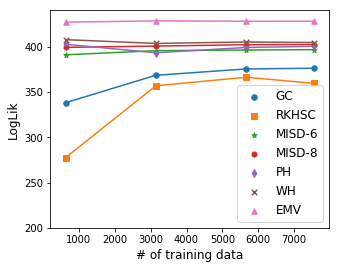

In [778]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.scatter(num_training,gc_logl,s=30, marker='o',label='GC')
axs.plot(num_training,gc_logl)
axs.scatter(num_training,rkhs_logl,s=30, marker='s',label='RKHSC')
axs.plot(num_training,rkhs_logl)
axs.scatter(num_training,misd_6_logl,s=30, marker='*',label='MISD-6')
axs.plot(num_training,misd_6_logl)
axs.scatter(num_training,misd_8_logl,s=30, marker='h',label='MISD-8')
axs.plot(num_training,misd_8_logl)
axs.scatter(num_training,ph_logl,s=30, marker='d',label='PH')
axs.plot(num_training,ph_logl)
axs.scatter(num_training,wh_logl,s=30, marker='x',label='WH')
axs.plot(num_training,wh_logl)
axs.scatter(num_training,var_logl,s=30, marker='^',label='EMV')
axs.plot(num_training,var_logl)
plt.xlabel('# of training data',fontsize=12)
plt.ylabel('LogLik',fontsize=12)
plt.ylim(200,440)
plt.legend(fontsize=12)

plt.savefig('c:/Users/zho045/Desktop/logl_collision',bbox_inches = 'tight')
plt.show()

In [1106]:
def time_rescaling(points_hawkes,mu,phi,T_phi): # mu is constant phi is piecewise
    N=len(points_hawkes)
    delta_tau=T_phi/len(phi)
    points_rescale=[]
    for i in range(N):
        time_rescale=mu*points_hawkes[i]
        for j in range(i):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi: 
                time_rescale+=sum(phi*delta_tau)
            else: 
                time_rescale+=sum(phi[:int(tij/delta_tau)]*delta_tau)
                time_rescale+=phi[int(tij/delta_tau)]*delta_tau*(tij/delta_tau-int(tij/delta_tau))
        points_rescale.append(time_rescale)
    return points_rescale

In [1107]:
def time_rescaling_exp(points_hawkes,parameters):
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    N=len(points_hawkes)
    points_rescale=[]
    for i in range(N):
        time_rescale=mu*points_hawkes[i]
        for j in range(i):
            tij=points_hawkes[i]-points_hawkes[j]
            time_rescale+=alpha/beta*(1-np.exp(-beta*tij))
        points_rescale.append(time_rescale)
    return points_rescale

In [1108]:
def time_rescaling_mu(points_hawkes,mu,phi,T_phi,T): ## mu is changing over time
    N=len(points_hawkes)
    delta_tau=T_phi/len(phi)
    delta_t=T/len(mu)
    points_rescale=[]
    for i in range(N):
        time_rescale=0
        time_rescale+=sum(mu[:int(points_hawkes[i]/delta_t)]*delta_t)
        time_rescale+=mu[int(points_hawkes[i]/delta_t)]*delta_t*(points_hawkes[i]/delta_t-int(points_hawkes[i]/delta_t))
        for j in range(i):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi: 
                time_rescale+=sum(phi*delta_tau)
            else: 
                time_rescale+=sum(phi[:int(tij/delta_tau)]*delta_tau)
                time_rescale+=phi[int(tij/delta_tau)]*delta_tau*(tij/delta_tau-int(tij/delta_tau))
        points_rescale.append(time_rescale)
    return points_rescale

In [1109]:
def time_rescaling_inhomopoisson(points_poisson, lamda, T):
    N=len(points_poisson)
    delta_t=T/len(lamda)
    points_rescale=[]
    for i in range(N):
        time_rescale=0
        time_rescale+=sum(lamda[:int(points_poisson[i]/delta_t)]*delta_t)
        time_rescale+=lamda[int(points_poisson[i]/delta_t)]*delta_t*(points_poisson[i]/delta_t-int(points_poisson[i]/delta_t))
        points_rescale.append(time_rescale)
    return points_rescale

In [1110]:
lamda_rkhs=np.array([0.19965649, 0.24747497, 0.29659336, 0.34611186, 0.39525367,
       0.44343896, 0.49034415, 0.53594136, 0.58051618, 0.6246653 ,
       0.66927897, 0.7155157 , 0.76477752, 0.81869281, 0.87911053,
       0.9481047 , 1.02798197, 1.12127968, 1.23073772, 1.35922652,
       1.50961632, 1.68457986, 1.88633129, 2.11631715, 2.37488894,
       2.66099803, 2.97196092, 3.30334324, 3.64900387, 4.00132567,
       4.35163814, 4.69081215, 5.00998148, 5.30132323, 5.5588137 ,
       5.77887041, 5.96079574, 6.10695411, 6.22264019, 6.31562817,
       6.39542769, 6.47230652, 6.55616939, 6.65540363, 6.77581243,
       6.91975481, 7.08559722, 7.26755605, 7.4559751 , 7.63804007,
       7.79888607, 7.92301016, 7.9958609 , 8.0054486 , 7.94380565,
       7.80813062, 7.60147413, 7.3328678 , 7.0168567 , 6.67246382,
       6.32168367, 5.98766171, 5.69275693, 5.45670019, 5.29504664,
       5.21807864, 5.23025102, 5.3301947 , 5.5112191 , 5.76219169,
       6.06863489, 6.41387204, 6.78007639, 7.14912339, 7.50320784,
       7.82524909, 8.09915767, 8.31006362, 8.44460563, 8.49135177,
       8.44137275, 8.28892998, 8.03218582, 7.67380562, 7.22130978,
       6.68705284, 6.08775321, 5.4435635 , 4.77674478, 4.11007505,
       3.4651699 , 2.8609131 , 2.31218265, 1.82901731, 1.41630529,
       1.07400423, 0.79782993, 0.58029367, 0.4119312 , 0.28255644])

In [1111]:
lamda_gc=np.array([0.89007704, 0.86294998, 0.83826827, 0.8171089 , 0.80020691,
       0.78787569, 0.78000316, 0.7761269 , 0.77557848, 0.77767234,
       0.78189973, 0.78807955, 0.79642678, 0.80752518, 0.82222584,
       0.84151925, 0.86643684, 0.89802693, 0.93742781, 0.98603441,
       1.04573031, 1.11913704, 1.20982078, 1.3223926 , 1.46243797,
       1.63620888, 1.85001169, 2.10924827, 2.41714858, 2.77338049,
       3.1728864 , 3.60536291, 4.05566305, 4.50508272, 4.93317875,
       5.3196772 , 5.64621632, 5.89794012, 6.06504529, 6.14418573,
       6.13931766, 6.06144061, 5.92695459, 5.75491248, 5.56395073,
       5.36980902, 5.18405529, 5.01413447, 4.86442466, 4.73775664,
       4.63683536, 4.56514212, 4.52712615, 4.52773127, 4.57146776,
       4.66129597, 4.79757144, 4.97727786, 5.19377021, 5.43721202,
       5.6957298 , 5.95701319, 6.20980313, 6.44466007, 6.65371336,
       6.82963456, 6.96454668, 7.04970224, 7.07643963, 7.03827709,
       6.93331891, 6.76581403, 6.54598803, 6.28807104, 6.0072966 ,
       5.71704152, 5.42705608, 5.14313928, 4.86801959, 4.60284212,
       4.34858567, 4.1068929 , 3.88010835, 3.67066397, 3.48018822,
       3.30875998, 3.15460402, 3.01432902, 2.88362798, 2.75822936,
       2.63481475, 2.51162455, 2.38857962, 2.26692819, 2.14860179,
       2.03554158, 1.92921157, 1.83039462, 1.73924578, 1.65550364])

In [722]:
points_rescale_MISD_6=time_rescaling(np.sort(training[15]),u_misd_6,phi_misd_6,T_phi)

In [723]:
points_rescale_MISD_6=1-np.exp(-np.array(points_rescale_MISD_6)+np.array([points_rescale_MISD_6[0]]+points_rescale_MISD_6[:-1]))

In [759]:
points_rescale_MISD_8=time_rescaling(np.sort(training[15]),u_misd_8,phi_misd_8,T_phi)

In [760]:
points_rescale_MISD_8=1-np.exp(-np.array(points_rescale_MISD_8)+np.array([points_rescale_MISD_8[0]]+points_rescale_MISD_8[:-1]))

In [724]:
points_rescale_wh=time_rescaling(np.sort(training[15]),u_wh,phi_wh,T_phi)

In [725]:
points_rescale_wh=1-np.exp(-np.array(points_rescale_wh)+np.array([points_rescale_wh[0]]+points_rescale_wh[:-1]))

In [749]:
points_rescale_ph=time_rescaling_exp(np.sort(training[15]),res_ave)

In [750]:
points_rescale_ph=1-np.exp(-np.array(points_rescale_ph)+np.array([points_rescale_ph[0]]+points_rescale_ph[:-1]))

In [728]:
points_rescale_var=time_rescaling_mu(np.sort(training[15]),mu_var,phi_var,T_phi,T)

In [729]:
points_rescale_var=1-np.exp(-np.array(points_rescale_var)+np.array([points_rescale_var[0]]+points_rescale_var[:-1]))

In [743]:
points_rescale_rkhs=time_rescaling_inhomopoisson(np.sort(training[15]),lamda_rkhs,T)

In [744]:
points_rescale_rkhs=1-np.exp(-np.array(points_rescale_rkhs)+np.array([points_rescale_rkhs[0]]+points_rescale_rkhs[:-1]))

In [755]:
points_rescale_gc=time_rescaling_inhomopoisson(np.sort(training[15]),lamda_gc,T)

In [756]:
points_rescale_gc=1-np.exp(-np.array(points_rescale_gc)+np.array([points_rescale_gc[0]]+points_rescale_gc[:-1]))

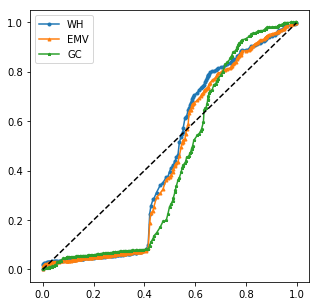

In [779]:
plt.figure(1,figsize=(5,5))
a = np.random.uniform(0,1,len(points_rescale_MISD_6))
percs = np.linspace(0,100,201)
qn_a = np.percentile(a, percs)
# qn_misd_6 = np.percentile(points_rescale_MISD_6, percs)
qn_misd_8 = np.percentile(points_rescale_MISD_8, percs)
qn_ph = np.percentile(points_rescale_ph, percs)
qn_wh = np.percentile(points_rescale_wh, percs)
qn_var = np.percentile(points_rescale_var, percs)
qn_rkhs = np.percentile(points_rescale_rkhs, percs)
qn_gc = np.percentile(points_rescale_gc, percs)
# plt.plot(qn_a,qn_misd_6, ls='-', marker="o",markersize=3,label='MISD-6')
# plt.plot(qn_a,qn_misd_8, ls='-', marker="o",markersize=3,label='MISD-8')
# plt.plot(qn_a,qn_ph, ls='-', marker="o",markersize=3,label='PH')
plt.plot(qn_a,qn_wh, ls='-', marker="o",markersize=3,label='WH')
plt.plot(qn_a,qn_var, ls='-', marker="^",markersize=3,label='EMV')
plt.plot(qn_a,qn_rkhs, ls='-', marker="*",markersize=3,label='GC')
# plt.plot(qn_a,qn_gc, ls='-', marker="o",markersize=3,label='GC')

x = np.linspace(qn_a.min(),qn_a.max())
plt.plot(x,x, color="k", ls="--")
plt.legend()
plt.savefig('c:/Users/zho045/Desktop/QQ_collision',bbox_inches = 'tight')
plt.show()

## prediction point using history

In [1112]:
def intensity(t,history,parameters):    #left continue
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    intensity=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        intensity+=alpha*np.exp(-beta*(t-history[i]))
    return mu+intensity

In [1113]:
def hawkes_prediction_next(history,parameters,num): ## parametric Hawkes
    t_i_1_list=[]
    intensity_sup=intensity(history[-1],history,parameters)+parameters[1]
    while(len(t_i_1_list)<num):
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t_i_1=history[-1]+r
        D=uniform.rvs(loc=0,scale=1)
        intensity_t_i_1=intensity(t_i_1,history,parameters)
        assert intensity_t_i_1<=intensity_sup, 'sup is not sup'
        if D*intensity_sup<=intensity_t_i_1:
            t_i_1_list.append(t_i_1)
    return np.average(t_i_1_list)

In [1114]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [1128]:
def hawkes_prediction_next_discre_phi(history,mu,phi,T_phi,num):
    t_i_1_list=[]
    jump=max(phi)*30
    intensity_sup=intensity_discrete(history[-1],history,mu,phi,T_phi)+jump
    while(len(t_i_1_list)<num):
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t_i_1=history[-1]+r
        D=uniform.rvs(loc=0,scale=1)
        intensity_t_i_1=intensity_discrete(t_i_1,history,mu,phi,T_phi)
        assert intensity_t_i_1<=intensity_sup, print(intensity_t_i_1,intensity_sup)
        if D*intensity_sup<=intensity_t_i_1:
            t_i_1_list.append(t_i_1)
    return np.average(t_i_1_list)

In [1129]:
def intensity_discrete_phi_mu(t,history,u,g_mean,g_range,T):    #left continue
    mu=u
    N=len(g_mean)
    M=len(mu)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<g_range:
            intensity_mean+=g_mean[int(delta_t*N/g_range)]
    result=mu[int(t/T*M)]+intensity_mean
    return result

In [1130]:
def hawkes_prediction_next_discrete_phi_mu(history,mu,phi,T_phi,T,num):
    t_i_1_list=[]
    jump0=max(mu)-mu[int(history[-1]/(T/len(mu)))]
    jump1=max(phi)*20
    intensity_sup=intensity_discrete_phi_mu(history[-1],history,mu,phi,T_phi,T)+jump0+jump1
    while(len(t_i_1_list)<num):
        r=expon.rvs(scale=1/intensity_sup)
        t_i_1=history[-1]+r
        D=uniform.rvs(loc=0,scale=1)
        intensity_t_i_1=intensity_discrete_phi_mu(t_i_1,history,mu,phi,T_phi,T)
        assert intensity_t_i_1<=intensity_sup, 'sup is not sup'
        if D*intensity_sup<=intensity_t_i_1:
            t_i_1_list.append(t_i_1)
    return np.average(t_i_1_list)

In [1131]:
def poisson_prediction_next(history,lamda,T,num):
    t_i_1_list=[]
    intensity_sup=max(lamda[int(history[-1]/(T/len(lamda))):])
    while(len(t_i_1_list)<num):
        t_i_1=history[-1]
        while(1):
            r=expon.rvs(scale=1/intensity_sup)
            t_i_1+=r
            intensity_t_i_1=lamda[int(t_i_1/(T/len(lamda)))]
            assert intensity_t_i_1<=intensity_sup, 'sup is not sup'
            D=uniform.rvs(loc=0,scale=1)
            if D*intensity_sup<=intensity_t_i_1:
                t_i_1_list.append(t_i_1)
                break
    return np.average(t_i_1_list)

## PH prediction

In [1120]:
len(training[12])

603

In [1225]:
peerr_ph_ave=[]
for i in range(12,17):
    preerr_ph=[]
    for j in range(300):
        preerr_ph.append((training[i][100+j]-hawkes_prediction_next(training[i][:100+j],res_ave,400))**2)
    peerr_ph_ave.append((sum(np.array(preerr_ph)<0.015))/300)

In [1226]:
np.average(peerr_ph_ave)

0.6060000000000001

## GC prediction

In [1238]:
preerr_gc_ave=[]
for i in range(12,17):
    preerr_gc=[]
    for j in range(300):
        preerr_gc.append((training[i][100+j]-poisson_prediction_next(training[i][:100+j],lamda_gc,T,400))**2)
    preerr_gc_ave.append(sum(np.array(preerr_gc)<0.015)/300)

In [1219]:
sum(np.array(preerr_gc)<0.015)/400

0.2025

In [1239]:
np.average(preerr_gc_ave)

0.1733333333333333

## RKHS prediction

In [1240]:
preerr_rkhs_ave=[]
for i in range(12,17):
    preerr_rkhs=[]
    for j in range(300):
        preerr_rkhs.append((training[i][100+j]-poisson_prediction_next(training[i][:100+j],lamda_rkhs,T,400))**2)
    preerr_rkhs_ave.append(sum(np.array(preerr_rkhs)<0.015)/300)

In [1241]:
np.average(preerr_rkhs_ave)

0.292

## MISD-6 prediction

In [1230]:
preerr_misd_6_ave=[]
for i in range(12,17):
    preerr_misd_6=[]
    for j in range(300):
        preerr_misd_6.append((training[i][100+j]-hawkes_prediction_next_discre_phi(training[i][:100+j],u_misd_6,phi_misd_6,T_phi,400))**2)
    preerr_misd_6_ave.append(sum(np.array(preerr_misd_6)<0.015)/300)

In [1231]:
np.average(preerr_misd_6_ave)

0.6766666666666666

## MISD-8 prediction

In [1232]:
preerr_misd_8_ave=[]
for i in range(12,17):
    preerr_misd_8=[]
    for j in range(300):
        preerr_misd_8.append((training[i][100+j]-hawkes_prediction_next_discre_phi(training[i][:100+j],u_misd_8,phi_misd_8,T_phi,400))**2)
    preerr_misd_8_ave.append(sum(np.array(preerr_misd_8)<0.015)/300)

In [1233]:
np.average(preerr_misd_8_ave)

0.6766666666666666

## WH prediction

In [1234]:
preerr_wh_ave=[]
for i in range(12,17):
    preerr_wh=[]
    for j in range(300):
        preerr_wh.append((training[i][100+j]-hawkes_prediction_next_discre_phi(training[i][:100+j],u_wh,phi_wh,T_phi,400))**2)
    preerr_wh_ave.append(sum(np.array(preerr_wh)<0.015)/300)

In [1235]:
np.average(preerr_wh_ave)

0.6733333333333333

## EMV prediction

In [1236]:
preerr_emv_ave=[]
for i in range(12,17):
    preerr_emv=[]
    for j in range(300):
        preerr_emv.append((training[i][100+j]-hawkes_prediction_next_discrete_phi_mu(training[i][:100+j],mu_var,phi_var,T_phi,T,400))**2)
    preerr_emv_ave.append(sum(np.array(preerr_emv)<0.015)/300)

In [1237]:
np.average(preerr_emv_ave)

0.7173333333333333